In [1]:
#baseline GloVe with CNN, LSTM CLSTM, imbalanced data
#Final sheet, lets make it look cleaner by ingoring the warnings
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt
import time
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
embed_size = 300
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 30 # max number of words in a question to use

In [3]:
#Load the comibed and processed imbalance data
data=pd.read_csv('CrisisNLP_CP.csv')
data.head(5)

,label,text
0,infrastructure_and_utilities_damage,solar lamps public light electric poles solar ...
1,other_useful_information,another earthquake registered magnitude
2,other_useful_information,big show running cause massive earthquake noth...
3,infrastructure_and_utilities_damage,alaska airlines halts flights la cabo san luca...
4,other_useful_information,news update northern experiences powerful eart...


In [4]:
#randomize the data
np.random.seed(42)
data = data.sample(frac=1)
data = data.reset_index(drop=True)

In [5]:
#do a test train split 80 - 20
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(data['text'].astype(str), data['label'],
                                                    stratify=data['label'], 
                                                    test_size=0.20)

In [6]:
#Print the size of the data
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (14664,)
Test shape :  (3666,)


In [7]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=max_len)
test_X = pad_sequences(test_X, maxlen=max_len)
print(train_X.shape)

(14664, 30)


In [8]:
#transform labels into numericals
le = LabelEncoder()

train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [9]:
#Print class information 
le.classes_

array(['caution_and_advice', 'displaced_people_and_evacuations',
       'donation_needs_or_offers_or_volunteering_services',
       'infrastructure_and_utilities_damage', 'injured_or_dead_people',
       'missing_trapped_or_found_people', 'not_related_or_irrelevant',
       'other_useful_information', 'sympathy_and_emotional_support'],
      dtype=object)

In [10]:
#Define function to load Glove and create embedding matrix
#Get GLOVE from http://nlp.stanford.edu/data/glove.840B.300d.zip
def load_glove(word_index):
        EMBEDDING_FILE = 'glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE,encoding="utf-8"))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [11]:
embedding_matrix = load_glove(tokenizer.word_index)

In [12]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too
debug=0
if debug:
    embedding_matrix = np.random.randn(30000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

In [13]:
#print the shape of embedding matrix
np.shape(embedding_matrix)

(19566, 300)

In [14]:
#Function to test and train the model
def batch_run(n,model):
    n_epochs = n
    model = model
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    model.cpu()

    # Load train and test in CUDA Memory
    x_train = torch.tensor(train_X, dtype=torch.long).cpu()
    y_train = torch.tensor(train_y, dtype=torch.long).cpu()
    x_cv = torch.tensor(test_X, dtype=torch.long).cpu()
    y_cv = torch.tensor(test_y, dtype=torch.long).cpu()

    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_cv, y_cv)

    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    train_loss = []
    valid_loss = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Set model to train configuration
        model.train()
        avg_loss = 0.  
        for i, (x_batch, y_batch) in enumerate(train_loader):
            # Predict/Forward Pass
            y_pred = model(x_batch)
            # Compute loss
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)

        # Set model to validation configuration -Doesn't get trained here
        model.eval()        
        avg_val_loss = 0.
        val_preds = np.zeros((len(x_cv),len(le.classes_)))

        for i, (x_batch, y_batch) in enumerate(valid_loader):
            y_pred = model(x_batch).detach()
            avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
            # keep/store predictions
            val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

        # Check Accuracy
        val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
        train_loss.append(avg_loss)
        valid_loss.append(avg_val_loss)
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                    epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))
    return train_loss,valid_loss,val_preds

In [15]:
#Function to plot graph for train and valid loss
def plot_graph(epochs,train_loss,valid_loss):
    fig = plt.figure(figsize=(6,6))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

In [16]:
#Function to print classification report and plot confusion matrix graph
def conf_matrix(val_preds):
    y_true = [le.classes_[x] for x in test_y]
    y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
    print (classification_report(y_true, y_pred))
    skplt.metrics.plot_confusion_matrix(
        y_true, 
        y_pred,
        figsize=(5,5),x_tick_rotation=90)

In [17]:
#Model1 - CNN
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [2, 3, 4]
        num_filters = 32
        drp = 0.2
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(drp)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x) 
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [18]:
#Get Model1-CNN information 
print(CNN_Text())
print (sum([param.nelement() for param in CNN_Text().parameters()]))

CNN_Text(
  (embedding): Embedding(30000, 300)
  (convs1): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 300), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=96, out_features=9, bias=True)
)
5957169


In [19]:
#Model2-BiLSTM 
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.2
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [20]:
#Get Model2-BiLSTM information 
print(BiLSTM())
print (sum([param.nelement() for param in BiLSTM().parameters()]))

BiLSTM(
  (embedding): Embedding(30000, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=64, out_features=9, bias=True)
)
6074225


In [21]:
#Model3-CBiLSTM 
class CBiLSTM(nn.Module):
    
    def __init__(self):
        super(CBiLSTM, self).__init__()
        filter_sizes = [2, 3, 4]
        num_filters = 32
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
                
        self.hidden_size = 64
        drp = 0.1
        self.lstm = nn.LSTM(96, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        x = self.embedding(x) 
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = x.unsqueeze(1)
        
        h_lstm, _ = self.lstm(x)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [22]:
#Get Model3-CBiLSTM information
print(CBiLSTM())
print (sum([param.nelement() for param in BiLSTM().parameters()]))

CBiLSTM(
  (embedding): Embedding(30000, 300)
  (convs1): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 300), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 300), stride=(1, 1))
  )
  (lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=9, bias=True)
)
6074225


In [23]:
batch_size = 128 # how many samples to process at once
n_epochs=10
model_name1=CNN_Text()
model_name2=BiLSTM()
model_name3=CBiLSTM()

In [24]:
#Run the model1
train_loss,valid_loss,val_preds=batch_run(n_epochs,model_name1)

Epoch 1/10 	 loss=174.0550 	 val_loss=126.3503  	 val_acc=0.6735  	 time=38.59s
Epoch 2/10 	 loss=123.0038 	 val_loss=113.7608  	 val_acc=0.7043  	 time=15.74s
Epoch 3/10 	 loss=108.5387 	 val_loss=108.6709  	 val_acc=0.7149  	 time=16.55s
Epoch 4/10 	 loss=98.9175 	 val_loss=106.4925  	 val_acc=0.7179  	 time=16.45s
Epoch 5/10 	 loss=91.4360 	 val_loss=107.3899  	 val_acc=0.7275  	 time=17.12s
Epoch 6/10 	 loss=83.7340 	 val_loss=107.0909  	 val_acc=0.7226  	 time=17.06s
Epoch 7/10 	 loss=78.1491 	 val_loss=106.8782  	 val_acc=0.7267  	 time=16.71s
Epoch 8/10 	 loss=71.8262 	 val_loss=110.6489  	 val_acc=0.7188  	 time=16.89s
Epoch 9/10 	 loss=66.9422 	 val_loss=109.2341  	 val_acc=0.7264  	 time=17.47s
Epoch 10/10 	 loss=61.4355 	 val_loss=110.2374  	 val_acc=0.7207  	 time=17.10s


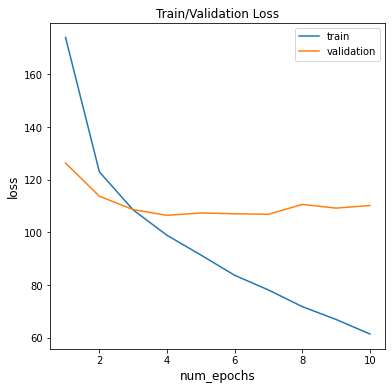

In [25]:
plot_graph(n_epochs,train_loss,valid_loss)

                                                   precision    recall  f1-score   support

                               caution_and_advice       0.72      0.37      0.49       208
                 displaced_people_and_evacuations       0.75      0.54      0.63       114
donation_needs_or_offers_or_volunteering_services       0.72      0.80      0.76       596
              infrastructure_and_utilities_damage       0.73      0.60      0.66       283
                           injured_or_dead_people       0.90      0.89      0.89       545
                  missing_trapped_or_found_people       0.53      0.40      0.46        82
                        not_related_or_irrelevant       0.68      0.58      0.63       429
                         other_useful_information       0.65      0.79      0.71      1025
                   sympathy_and_emotional_support       0.78      0.73      0.75       384

                                         accuracy                           0.72      36

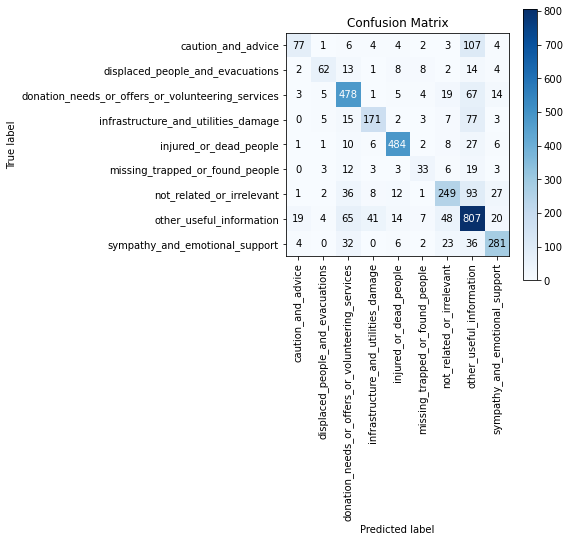

In [26]:
conf_matrix(val_preds)

In [27]:
#Run the model2
train_loss,valid_loss,val_preds=batch_run(n_epochs,model_name2)

Epoch 1/10 	 loss=211.2298 	 val_loss=143.9739  	 val_acc=0.6222  	 time=26.06s
Epoch 2/10 	 loss=136.7165 	 val_loss=122.7702  	 val_acc=0.6800  	 time=24.25s
Epoch 3/10 	 loss=118.2799 	 val_loss=114.0420  	 val_acc=0.6978  	 time=24.13s
Epoch 4/10 	 loss=107.3255 	 val_loss=108.3323  	 val_acc=0.7190  	 time=24.27s
Epoch 5/10 	 loss=98.6484 	 val_loss=107.2975  	 val_acc=0.7199  	 time=24.95s
Epoch 6/10 	 loss=92.5369 	 val_loss=106.8505  	 val_acc=0.7239  	 time=25.50s
Epoch 7/10 	 loss=85.3157 	 val_loss=109.2906  	 val_acc=0.7188  	 time=25.59s
Epoch 8/10 	 loss=78.6371 	 val_loss=110.8900  	 val_acc=0.7141  	 time=25.70s
Epoch 9/10 	 loss=71.9214 	 val_loss=113.5792  	 val_acc=0.7212  	 time=24.61s
Epoch 10/10 	 loss=66.1655 	 val_loss=120.3724  	 val_acc=0.7089  	 time=25.83s


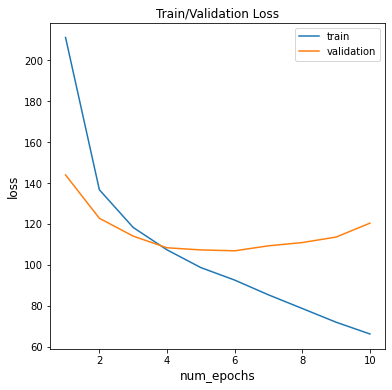

In [28]:
plot_graph(n_epochs,train_loss,valid_loss)

                                                   precision    recall  f1-score   support

                               caution_and_advice       0.57      0.49      0.53       208
                 displaced_people_and_evacuations       0.58      0.56      0.57       114
donation_needs_or_offers_or_volunteering_services       0.74      0.72      0.73       596
              infrastructure_and_utilities_damage       0.69      0.63      0.66       283
                           injured_or_dead_people       0.90      0.91      0.91       545
                  missing_trapped_or_found_people       0.63      0.33      0.43        82
                        not_related_or_irrelevant       0.74      0.50      0.60       429
                         other_useful_information       0.62      0.79      0.69      1025
                   sympathy_and_emotional_support       0.80      0.71      0.75       384

                                         accuracy                           0.71      36

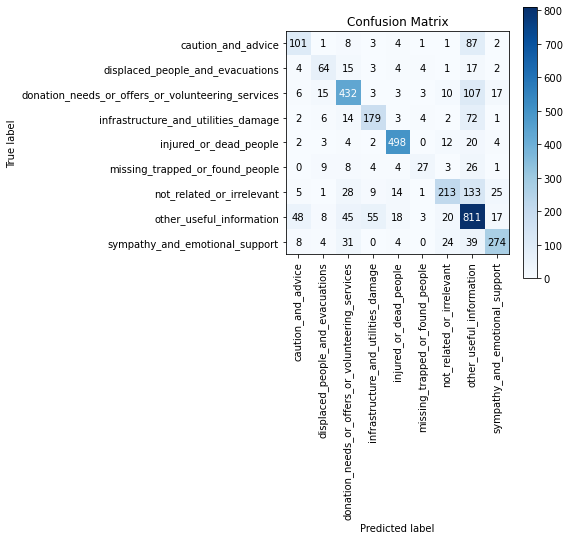

In [29]:
conf_matrix(val_preds)

In [30]:
#Run the model3
train_loss,valid_loss,val_preds=batch_run(n_epochs,model_name3)

Epoch 1/10 	 loss=195.8899 	 val_loss=135.7239  	 val_acc=0.6618  	 time=19.31s
Epoch 2/10 	 loss=123.7449 	 val_loss=113.8199  	 val_acc=0.7144  	 time=19.13s
Epoch 3/10 	 loss=101.7359 	 val_loss=111.1348  	 val_acc=0.7177  	 time=19.29s
Epoch 4/10 	 loss=85.7626 	 val_loss=113.3712  	 val_acc=0.7171  	 time=19.19s
Epoch 5/10 	 loss=71.7076 	 val_loss=121.0392  	 val_acc=0.6909  	 time=19.50s
Epoch 6/10 	 loss=58.3783 	 val_loss=132.1379  	 val_acc=0.6915  	 time=19.24s
Epoch 7/10 	 loss=44.3923 	 val_loss=147.3547  	 val_acc=0.6999  	 time=19.69s
Epoch 8/10 	 loss=34.0434 	 val_loss=157.3281  	 val_acc=0.6869  	 time=18.96s
Epoch 9/10 	 loss=26.2737 	 val_loss=177.1441  	 val_acc=0.6806  	 time=19.03s
Epoch 10/10 	 loss=21.2992 	 val_loss=200.6827  	 val_acc=0.6626  	 time=19.47s


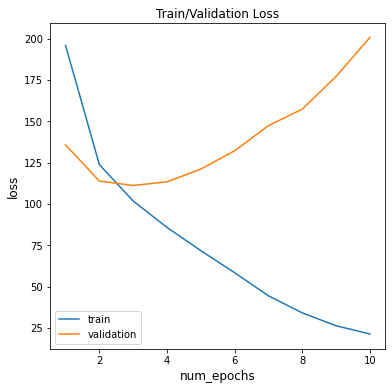

In [31]:
plot_graph(n_epochs,train_loss,valid_loss)

                                                   precision    recall  f1-score   support

                               caution_and_advice       0.56      0.36      0.44       208
                 displaced_people_and_evacuations       0.70      0.47      0.57       114
donation_needs_or_offers_or_volunteering_services       0.67      0.83      0.74       596
              infrastructure_and_utilities_damage       0.69      0.63      0.65       283
                           injured_or_dead_people       0.88      0.91      0.89       545
                  missing_trapped_or_found_people       0.34      0.34      0.34        82
                        not_related_or_irrelevant       0.47      0.66      0.55       429
                         other_useful_information       0.70      0.53      0.61      1025
                   sympathy_and_emotional_support       0.66      0.73      0.69       384

                                         accuracy                           0.66      36

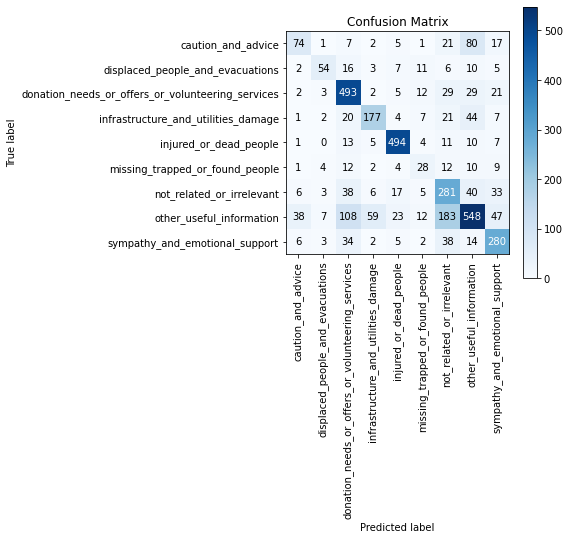

In [32]:
conf_matrix(val_preds)